In [1]:
# import
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import random
import torch.nn as nn
import torch.nn.functional as F
import warnings
import datetime
from copy import deepcopy
from diffusion_crt import *

def transform(x):
    return torch.log(x)-torch.log(1-x)

def re_transform(x):
    return 1/(1+torch.exp(-x))

def inverse_to_original(z, x_min, x_max):
    # Step 1: inverse logit
    u = 1 / (1 + torch.exp(-z))

    # Step 2: undo division by 1.02
    x_norm = u * 1.02

    # Step 3: undo +0.01 shift
    x_scaled = x_norm - 0.01

    # Step 4: undo min-max normalization
    x_original = x_scaled * (x_max - x_min) + x_min

    return x_original


def data_continuous_discrete(n_samples, dim, test_type, noise="gaussian", seed=None):
    if seed == None:
        np.random.seed()
    else:
        np.random.seed(seed)

    if noise == "gaussian":
        sampler = np.random.normal
    elif noise == "laplace":
        sampler = np.random.laplace
    elif noise == "uniform":
        sampler = np.random.uniform
        
        
    
    
    if dim ==1:
        z = sampler(size=(n_samples, 1))
        
        
        
        
        if test_type:
            eps1=0.33*sampler(size=(n_samples, 1))
            eps2=0.33*sampler(size=(n_samples, 1))
            x = z+eps1
            y = z+eps2
        else:
            eps1=0.33*sampler(size=(n_samples, 1))
            x = z+eps1
            y = z+eps1

        
            
    else:
        z = np.zeros(shape=(n_samples, dim))
        z[:,0:int(dim/2)]=sampler(size=(n_samples, int(dim/2)))
        z[:,int(dim/2):]=np.random.binomial(1,0.5,z[:,int(dim/2):].shape)*2-1
        
        
        
        
        if test_type:
            eps1=0.33*sampler(size=(n_samples, 1))
            eps2=0.33*sampler(size=(n_samples, 1))

            x=np.mean(z[:,0:int(2*dim/3)], axis=1).reshape(-1, 1)+eps1
            y=np.mean(z[:,0:int(2*dim/3)], axis=1).reshape(-1, 1)+eps2
        else:
            eps1=0.33*sampler(size=(n_samples, 1))
            x=np.mean(z[:,0:int(2*dim/3)], axis=1).reshape(-1, 1)+eps1
            y=np.mean(z[:,0:int(2*dim/3)], axis=1).reshape(-1, 1)+eps1
        


    return x, y, z, 'continuous_discrete', 'continuous_discrete'

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(999)

In [3]:
#data gen and plot
sns.set()
plt.rcParams['figure.figsize'] = (24, 18)        
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.title_fontsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
dz=20
num = 500 

device = torch.device('cuda')

dataset_y,_,dataset_x,_,_=data_continuous_discrete(n_samples=num, dim=dz, test_type=True, noise="gaussian", seed=999)
dataset_y=torch.tensor(dataset_y).float().to(device)
dataset_x=torch.tensor(dataset_x).float().to(device)

dataset_y=dataset_y.float().to(device)
dataset_x=dataset_x.float().to(device)

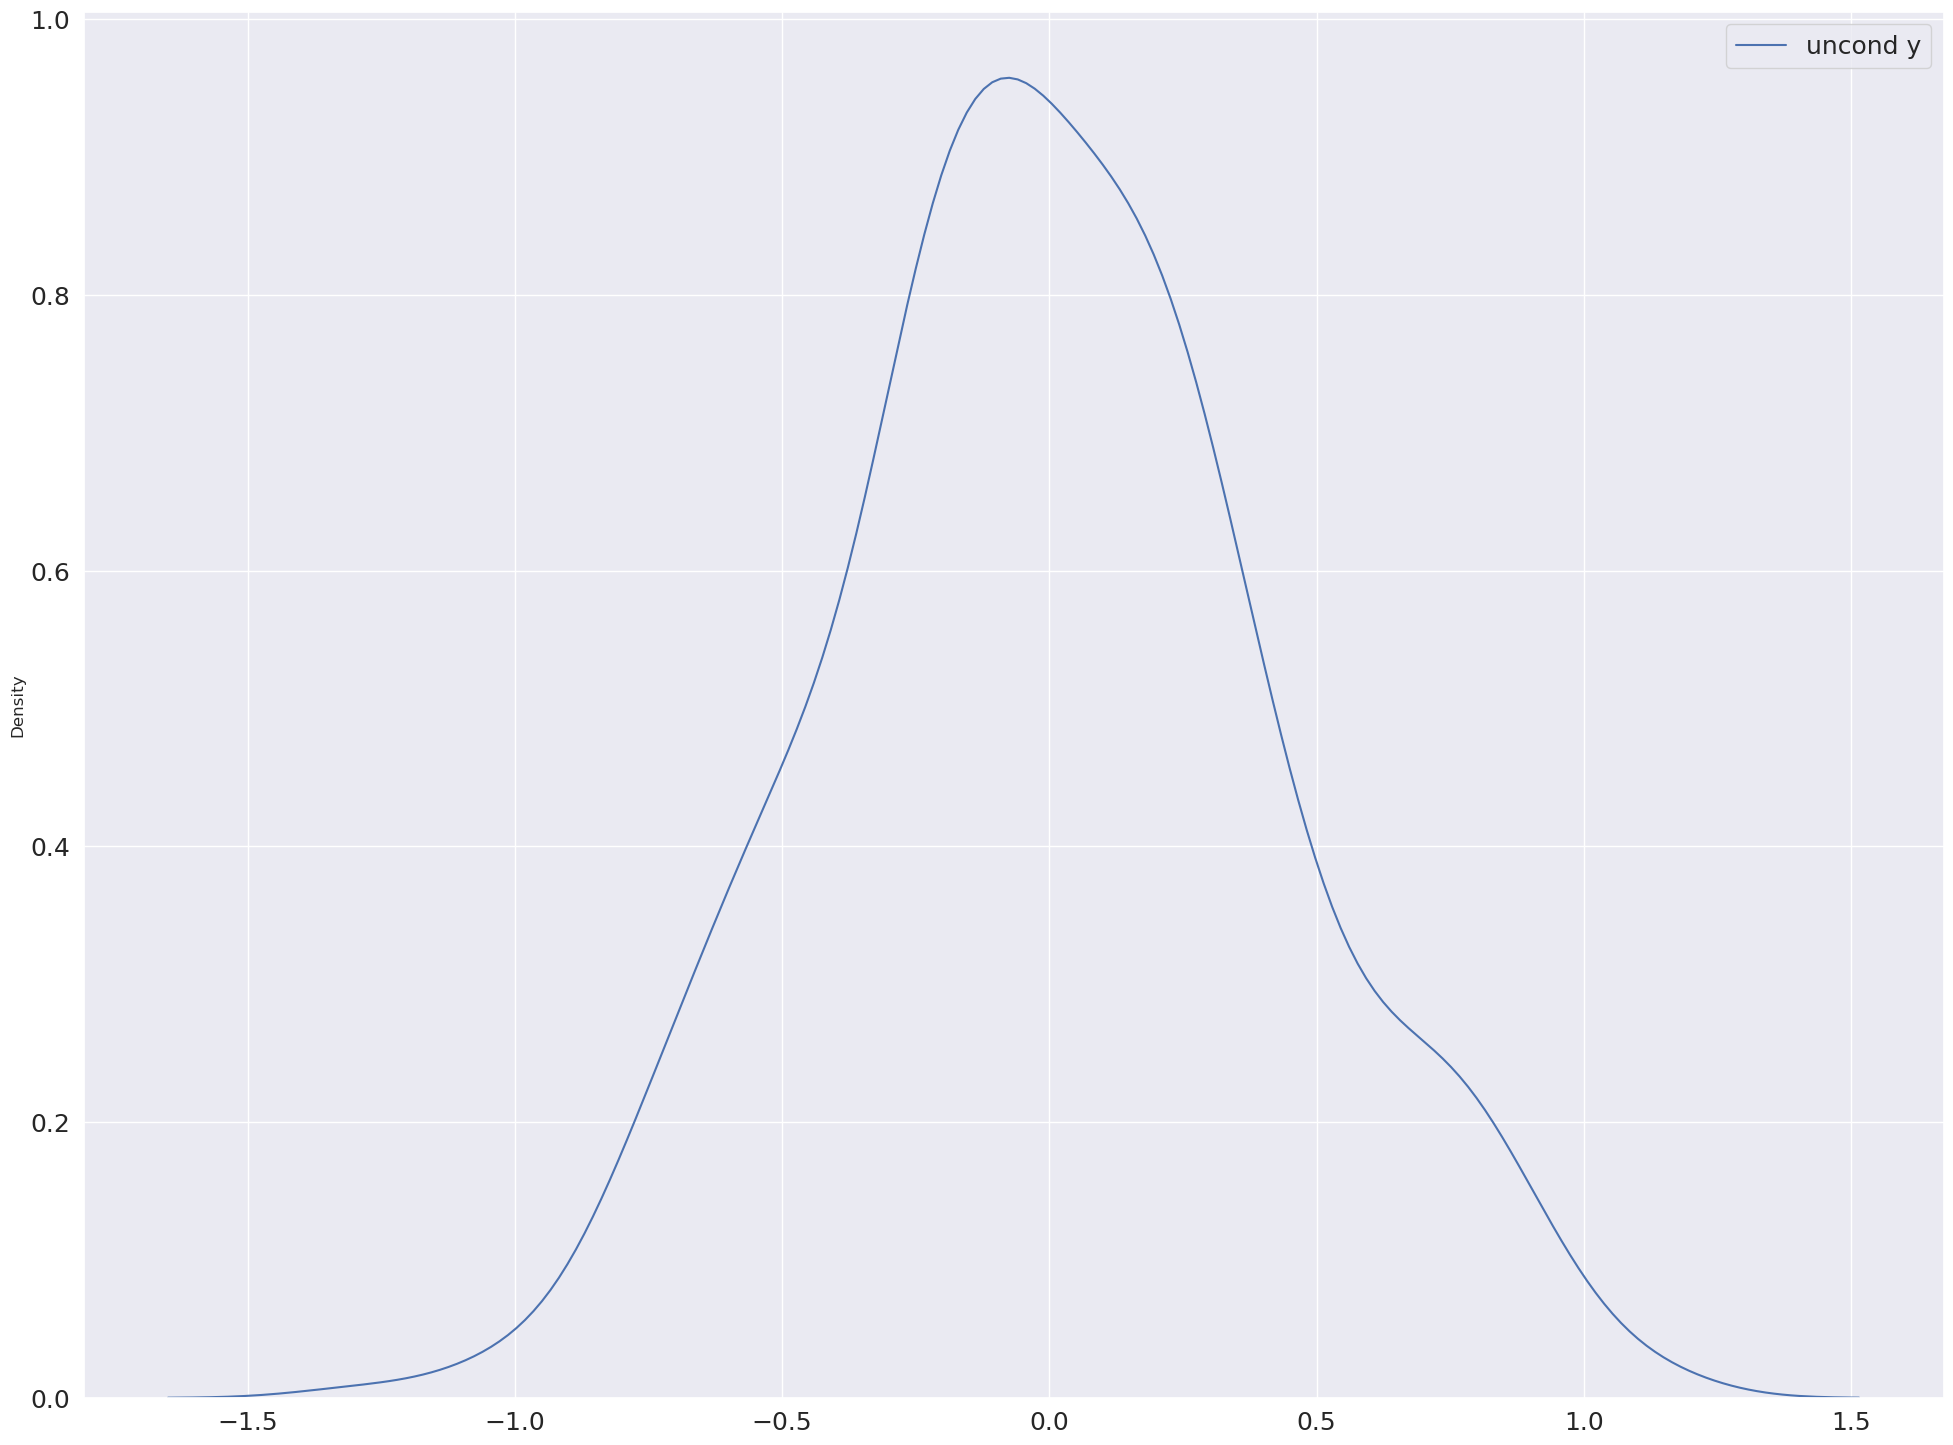

In [4]:
sns.kdeplot(dataset_y.view(-1).detach().cpu().numpy(), label = 'uncond y')
plt.legend()

In [5]:


dataset_x=dataset_x.to(device)
dataset_y=dataset_y.to(device)

x_min, x_max = dataset_x.min(), dataset_x.max()
y_min, y_max = dataset_y.min(), dataset_y.max()




In [6]:
x_normalized = (dataset_x - x_min) / (x_max - x_min) +0.01
y_normalized = (dataset_y - y_min) / (y_max - y_min) +0.01

In [7]:
x_normalized_transformed = transform(x_normalized/1.02).float().to(device)
y_normalized_transformed = transform(y_normalized/1.02).float().to(device)

In [8]:
num_steps = 1000
betas=make_beta_schedule(schedule="linear", num_timesteps=num_steps,start=1e-4, end=2e-2)
alphas=1-betas
alphas_bar=torch.cumprod(alphas,0).to(device)
alphas_bar_sqrt=torch.sqrt(alphas_bar)
one_minus_alphas_bar_sqrt=torch.sqrt(1-alphas_bar)

In [9]:
val_index = 450
dataloader = torch.utils.data.DataLoader(torch.cat([x_normalized_transformed[:val_index,:], y_normalized_transformed[:val_index,:]], dim=1), 
                                         batch_size=9999,shuffle=True, )

x_val = x_normalized_transformed[val_index:,:]
y_val = y_normalized_transformed[val_index:,:]

In [10]:
model = DiffusionModelWithEmbedding(input_dim=dataset_y.shape[1], 
                                time_steps=num_steps, embedding_dim=32,
                                cond_dim=dz,hidden_dim=16).to(device)

In [11]:
import copy

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epoch = 2000

ema2 = EMA(model)

best_val_loss = float("inf")

# ✅ 用来存最优模型参数（在内存里）
best_model_state = None
best_ema_state = None


for epoch in range(num_epoch):

    # ============================
    # Training
    # ============================
    model.train()
    total_train_loss = 0

    for idx, batch in enumerate(dataloader):

        batch_x = batch[:, :dz].to(device)
        batch_y = batch[:, dz:].to(device)

        loss = diffusion_loss_fn(
            model,
            batch_y,
            batch_x,
            alphas_bar_sqrt,
            one_minus_alphas_bar_sqrt,
            num_steps,
            device
        )

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

        # EMA update
        ema2.update(model)

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(dataloader)

    # ============================
    # Validation
    # ============================
    model.eval()
    with torch.no_grad():

        val_loss = diffusion_loss_fn(
            model,
            y_val.to(device),
            x_val.to(device),
            alphas_bar_sqrt,
            one_minus_alphas_bar_sqrt,
            num_steps,
            device
        )

    val_loss_value = val_loss.item()

    # ============================
    # Keep best model in memory
    # ============================
    if val_loss_value < best_val_loss:

        best_val_loss = val_loss_value

        # ✅ 深拷贝参数（存在 RAM 里）
        best_model_state = copy.deepcopy(model.state_dict())
        best_ema_state = copy.deepcopy(ema2.state_dict())

        print(f"✅ Best model updated at epoch {epoch}, val_loss={best_val_loss:.6f}")

    # ============================
    # Logging
    # ============================
    print(f"Epoch [{epoch}/{num_epoch}] "
          f"Train Loss: {avg_train_loss:.6f} "
          f"Val Loss: {val_loss_value:.6f}")


model.load_state_dict(best_model_state)
ema2.load_state_dict(best_ema_state)

print("🎉 Training finished!")
print("✅ Best model restored from memory")
print("Best Val Loss =", best_val_loss)

✅ Best model updated at epoch 0, val_loss=1.024514
Epoch [0/2000] Train Loss: 1.116219 Val Loss: 1.024514
Epoch [1/2000] Train Loss: 1.049853 Val Loss: 1.030540
Epoch [2/2000] Train Loss: 0.913901 Val Loss: 1.183200
Epoch [3/2000] Train Loss: 1.062811 Val Loss: 1.231592
✅ Best model updated at epoch 4, val_loss=1.000334
Epoch [4/2000] Train Loss: 1.074423 Val Loss: 1.000334
✅ Best model updated at epoch 5, val_loss=0.926325
Epoch [5/2000] Train Loss: 1.157229 Val Loss: 0.926325
Epoch [6/2000] Train Loss: 1.075813 Val Loss: 1.059420
Epoch [7/2000] Train Loss: 0.984507 Val Loss: 1.139939
✅ Best model updated at epoch 8, val_loss=0.792166
Epoch [8/2000] Train Loss: 1.032673 Val Loss: 0.792166
Epoch [9/2000] Train Loss: 0.930364 Val Loss: 0.983379
Epoch [10/2000] Train Loss: 0.945544 Val Loss: 1.248340
Epoch [11/2000] Train Loss: 0.941699 Val Loss: 1.146925
Epoch [12/2000] Train Loss: 1.096681 Val Loss: 1.161443
✅ Best model updated at epoch 13, val_loss=0.762495
Epoch [13/2000] Train Loss

In [12]:
y_seq_crt = sample_from_diff(model, num_samples=x_normalized_transformed.shape[0], 
                                    input_dim=y_normalized_transformed.shape[1],
                                    cond=torch.tensor(x_normalized_transformed).to(device).float(),
                                    alphas_bar_sqrt=alphas_bar_sqrt,
                                    one_minus_alphas_bar_sqrt=one_minus_alphas_bar_sqrt,
                                    betas=betas,
                                    num_steps=num_steps,
                                    device=device)

/tmp/ipykernel_2097912/1041496781.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond=torch.tensor(x_normalized_transformed).to(device).float(),


In [13]:
y_gen = inverse_to_original(y_seq_crt[-1],y_min,y_max)


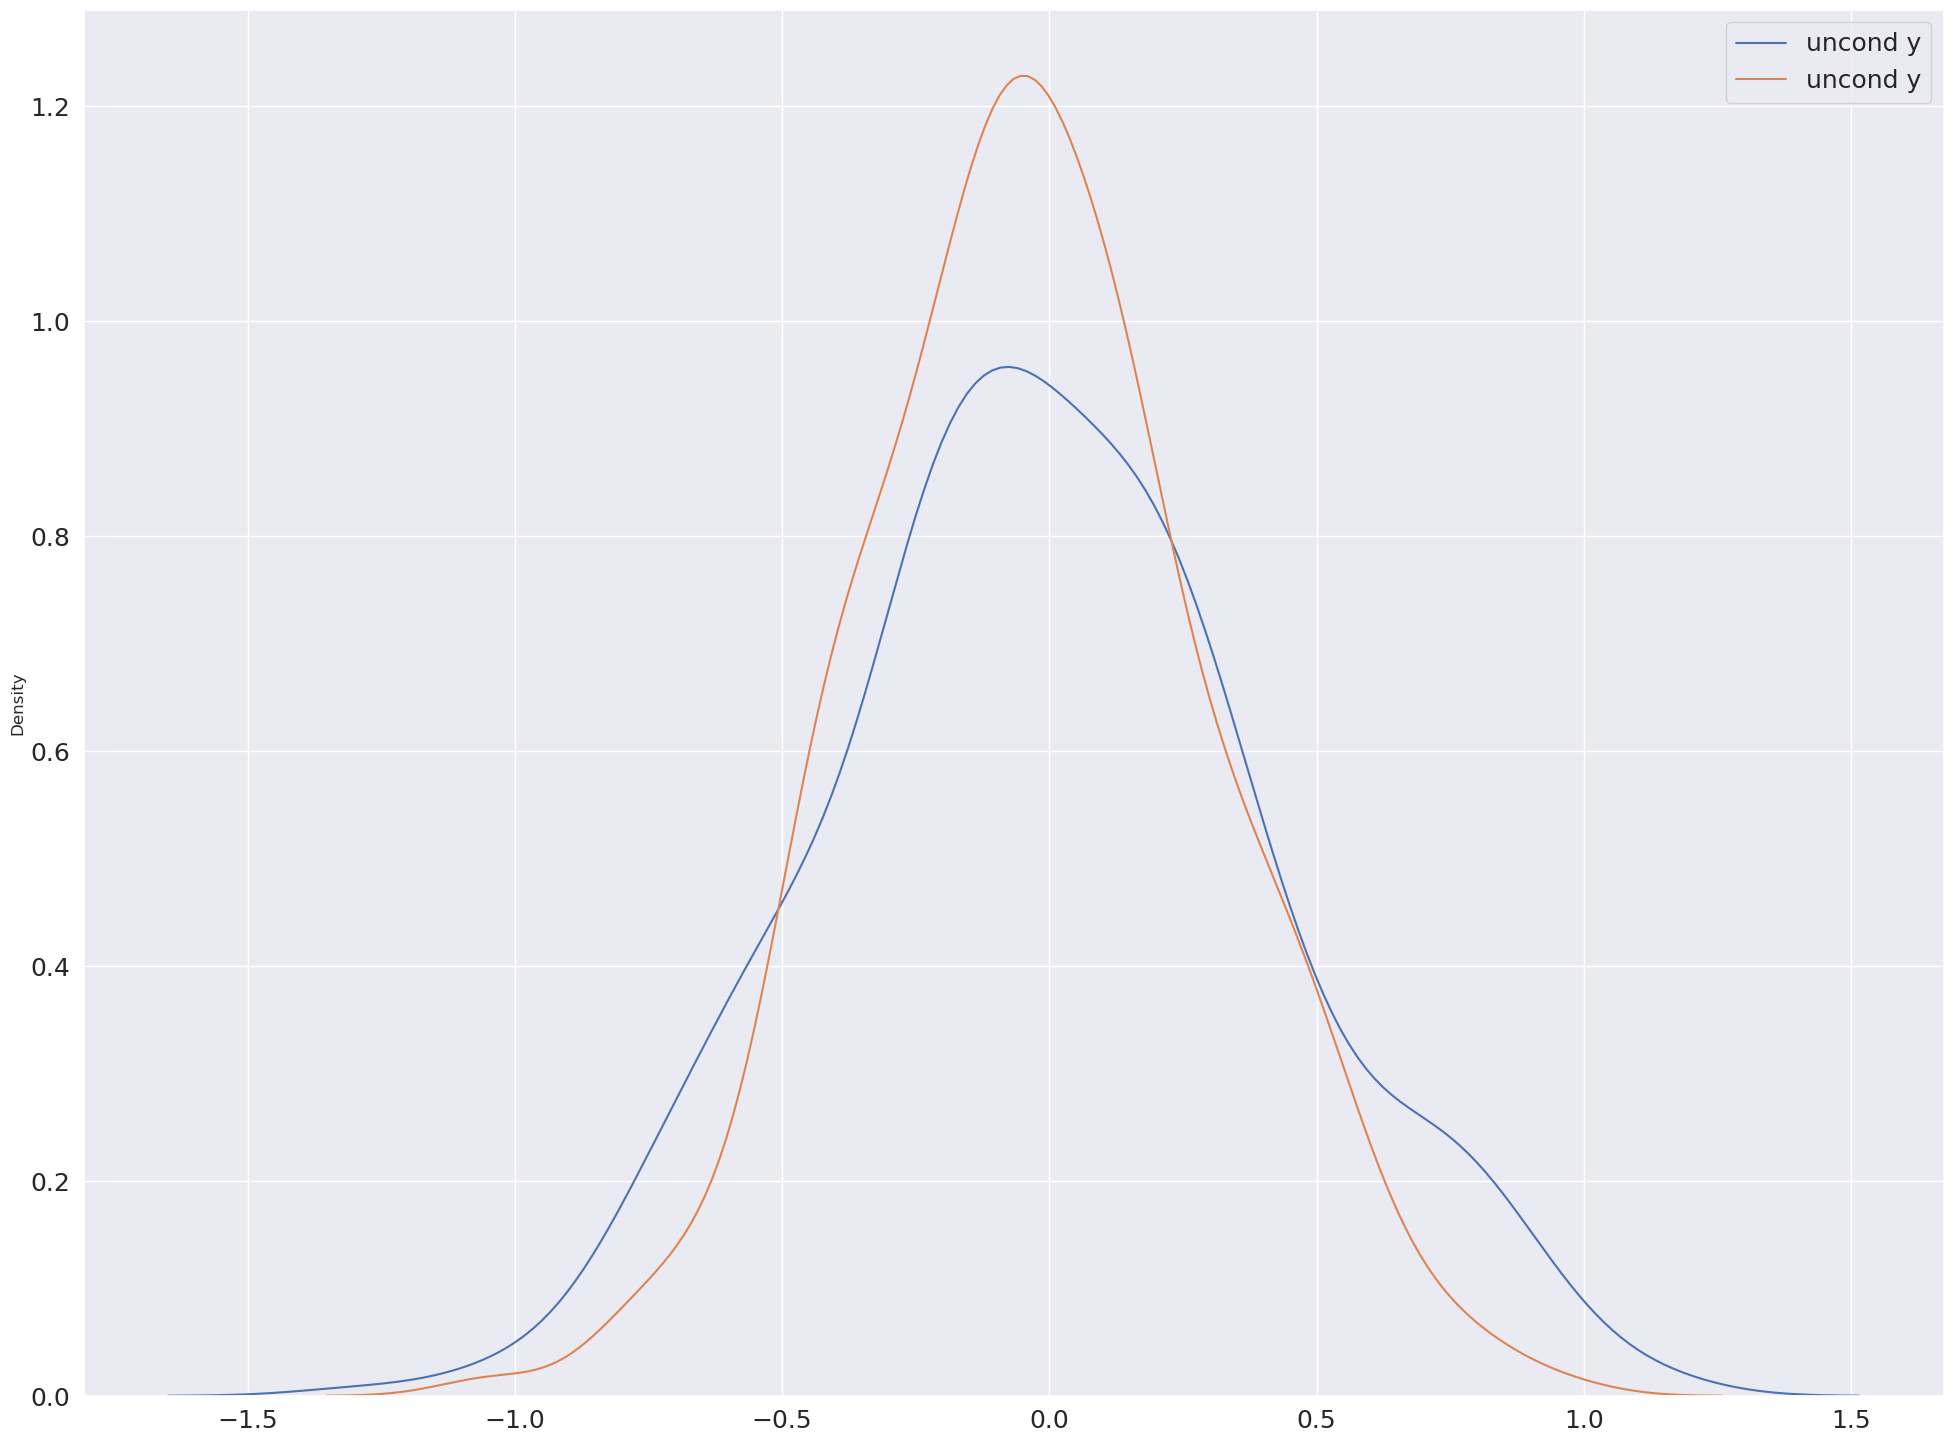

In [14]:
sns.kdeplot(dataset_y.view(-1).detach().cpu().numpy(), label = 'uncond y')
sns.kdeplot(y_gen.view(-1).detach().cpu().numpy(), label = 'uncond y')

plt.legend()

In [15]:
num_test = 500
z_fix=(torch.ones(num_test,int(dz/2))*torch.randn((1,int(dz/2)))).to(device)
binominal_fix=np.ones((num_test,int(dz/2)))*np.random.binomial(1,0.5,(1,int(dz/2)))
binominal_fix=torch.tensor(binominal_fix).float().to(device)
z_fix=torch.cat([z_fix,binominal_fix],axis=1)


y_fix=torch.mean(z_fix[:,:int(2*dz/3)],axis=1).reshape(-1,1)+0.33*torch.randn((num_test,1)).to(device)
y_fix=y_fix.to(device)

In [16]:
y_fix=y_fix.to(device)
z_fix_normalized = (z_fix - x_min) / (x_max - x_min) +0.01
z_fix_normalized_transformed = transform(z_fix_normalized/1.02).float().to(device)

y_seq = sample_from_diff(model, num_samples=x_normalized_transformed.shape[0], 
                                input_dim=y_fix.shape[1],
                                cond=torch.tensor(z_fix_normalized_transformed).to(device).float(),
                                alphas_bar_sqrt=alphas_bar_sqrt,
                                one_minus_alphas_bar_sqrt=one_minus_alphas_bar_sqrt,
                                betas=betas,
                                num_steps=num_steps,
                                device=device)


/tmp/ipykernel_2097912/2147617884.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond=torch.tensor(z_fix_normalized_transformed).to(device).float(),


In [17]:
y_sorted = inverse_to_original(y_seq[-1],y_min,y_max).view(-1).sort().values

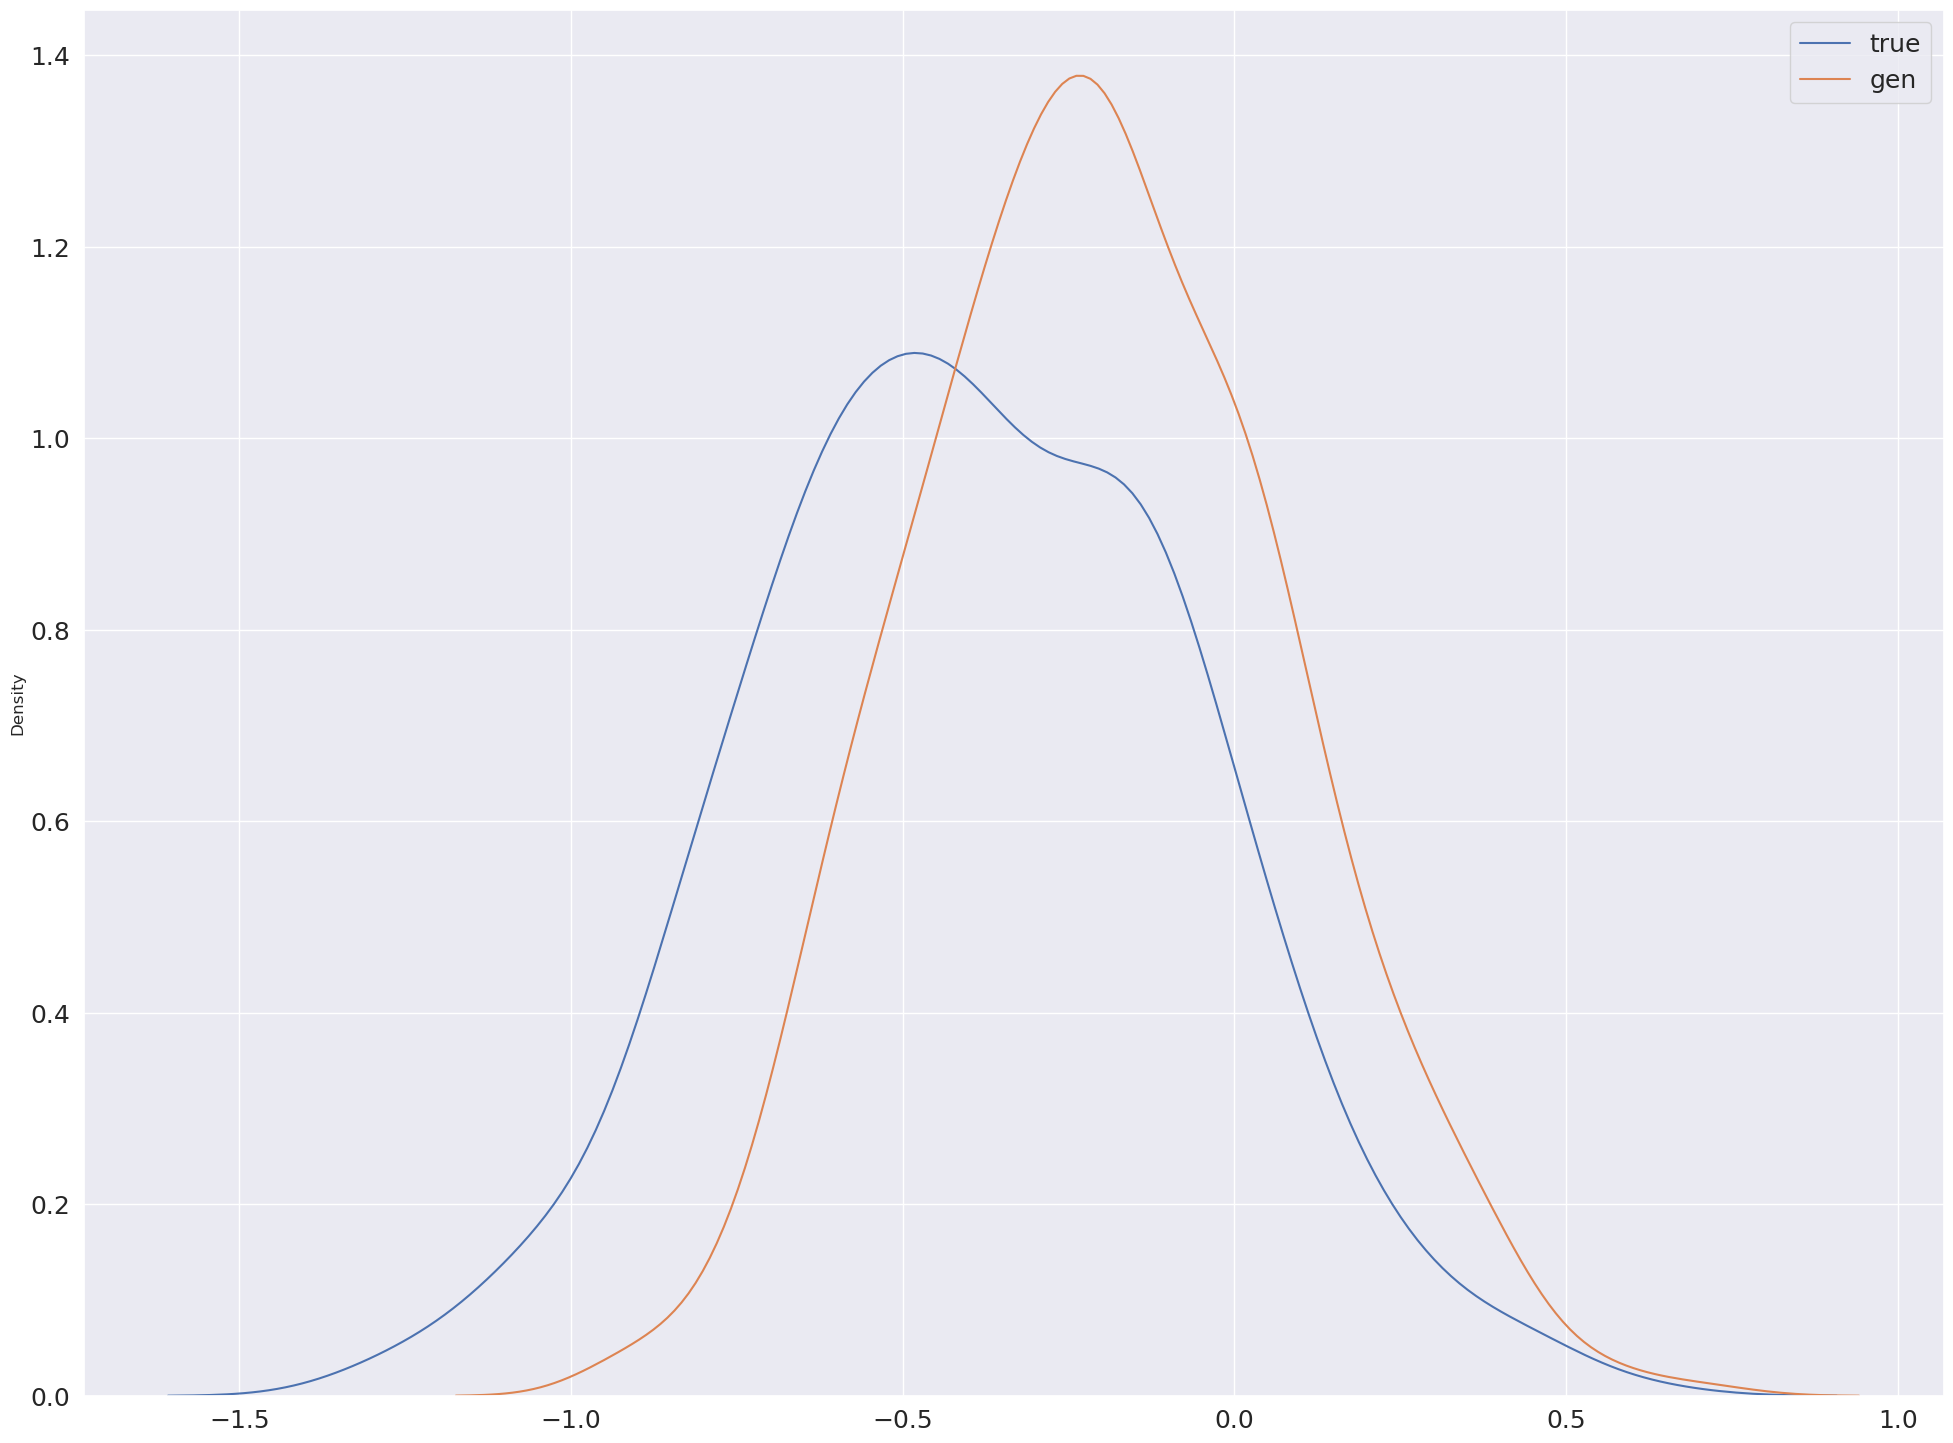

In [18]:
sns.kdeplot(y_fix.view(-1).detach().cpu().numpy(), label = 'true')
sns.kdeplot(y_sorted.view(-1).detach().cpu().numpy(), label = 'gen')
plt.legend()

In [19]:
quantile_005=0.05
quantile_025=0.25
quantile_050=0.50
quantile_075=0.75
quantile_095=0.95
result=[]
repeat=100
num_test=500
for i in range(repeat):
    seed_everything(i+40)
    print(i)
    z_fix=(torch.ones(num_test,int(dz/2))*torch.randn((1,int(dz/2)))).to(device)
    binominal_fix=np.ones((num_test,int(dz/2)))*np.random.binomial(1,0.5,(1,int(dz/2)))
    binominal_fix=torch.tensor(binominal_fix).float().to(device)
    z_fix=torch.cat([z_fix,binominal_fix],axis=1)



    y_fix=torch.mean(z_fix[:,:int(2*dz/3)],axis=1).reshape(-1,1)+0.33*torch.randn((num_test,1)).to(device)
    y_fix=y_fix.to(device)

    
    z_fix_normalized = (z_fix - x_min) / (x_max - x_min) +0.01
    z_fix_normalized_transformed = transform(z_fix_normalized/1.02).float().to(device)

    y_seq = sample_from_diff(model, num_samples=x_normalized_transformed.shape[0], 
                                    input_dim=y_fix.shape[1],
                                    cond=torch.tensor(z_fix_normalized_transformed).to(device).float(),
                                    alphas_bar_sqrt=alphas_bar_sqrt,
                                    one_minus_alphas_bar_sqrt=one_minus_alphas_bar_sqrt,
                                    betas=betas,
                                    num_steps=num_steps,
                                    device=device)
    y_sorted = inverse_to_original(y_seq[-1],y_min,y_max).view(-1).sort().values
    #MSE of quantile
    x_sorted=(y_fix).view(-1).sort().values
    mse_005=(y_sorted[round(num_test*quantile_005)]-x_sorted[round(num_test*quantile_005)])**2
    mse_025=(y_sorted[round(num_test*quantile_025)]-x_sorted[round(num_test*quantile_025)])**2
    mse_050=(y_sorted[round(num_test*quantile_050)]-x_sorted[round(num_test*quantile_050)])**2
    mse_075=(y_sorted[round(num_test*quantile_075)]-x_sorted[round(num_test*quantile_075)])**2
    mse_095=(y_sorted[round(num_test*quantile_095)]-x_sorted[round(num_test*quantile_095)])**2
    result.append((mse_005.detach(),mse_025.detach(),mse_050.detach(),mse_075.detach(),mse_095.detach(),mse_005.detach()+mse_025.detach()+mse_050.detach()+mse_075.detach()+mse_095.detach()))
    print(result[-1][-1])

    
quantile_005_mse=0
quantile_025_mse=0
quantile_050_mse=0
quantile_075_mse=0
quantile_095_mse=0
quantile_total=0
for i in result:
    quantile_005_mse+=i[0]
    quantile_025_mse+=i[1]
    quantile_050_mse+=i[2]
    quantile_075_mse+=i[3]
    quantile_095_mse+=i[4]
    quantile_total+=i[5]
    
print(f'result:{quantile_005_mse/repeat,quantile_025_mse/repeat,quantile_050_mse/repeat,quantile_075_mse/repeat,quantile_095_mse/repeat,quantile_total/repeat}')

0


/tmp/ipykernel_2097912/840498014.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond=torch.tensor(z_fix_normalized_transformed).to(device).float(),


tensor(0.2012, device='cuda:0')
1
tensor(0.0456, device='cuda:0')
2
tensor(0.1260, device='cuda:0')
3
tensor(0.2313, device='cuda:0')
4
tensor(0.0354, device='cuda:0')
5
tensor(0.0244, device='cuda:0')
6
tensor(0.3376, device='cuda:0')
7
tensor(0.1213, device='cuda:0')
8
tensor(0.0950, device='cuda:0')
9
tensor(0.1374, device='cuda:0')
10
tensor(0.0262, device='cuda:0')
11
tensor(0.5271, device='cuda:0')
12
tensor(0.0261, device='cuda:0')
13
tensor(0.0263, device='cuda:0')
14
tensor(0.0344, device='cuda:0')
15
tensor(0.0622, device='cuda:0')
16
tensor(0.0502, device='cuda:0')
17
tensor(0.1871, device='cuda:0')
18
tensor(0.0243, device='cuda:0')
19
tensor(0.0475, device='cuda:0')
20
tensor(0.5566, device='cuda:0')
21
tensor(0.0348, device='cuda:0')
22
tensor(0.4016, device='cuda:0')
23
tensor(0.1229, device='cuda:0')
24
tensor(0.0149, device='cuda:0')
25
tensor(0.0582, device='cuda:0')
26
tensor(0.0223, device='cuda:0')
27
tensor(0.0744, device='cuda:0')
28
tensor(0.2296, device='cuda:0

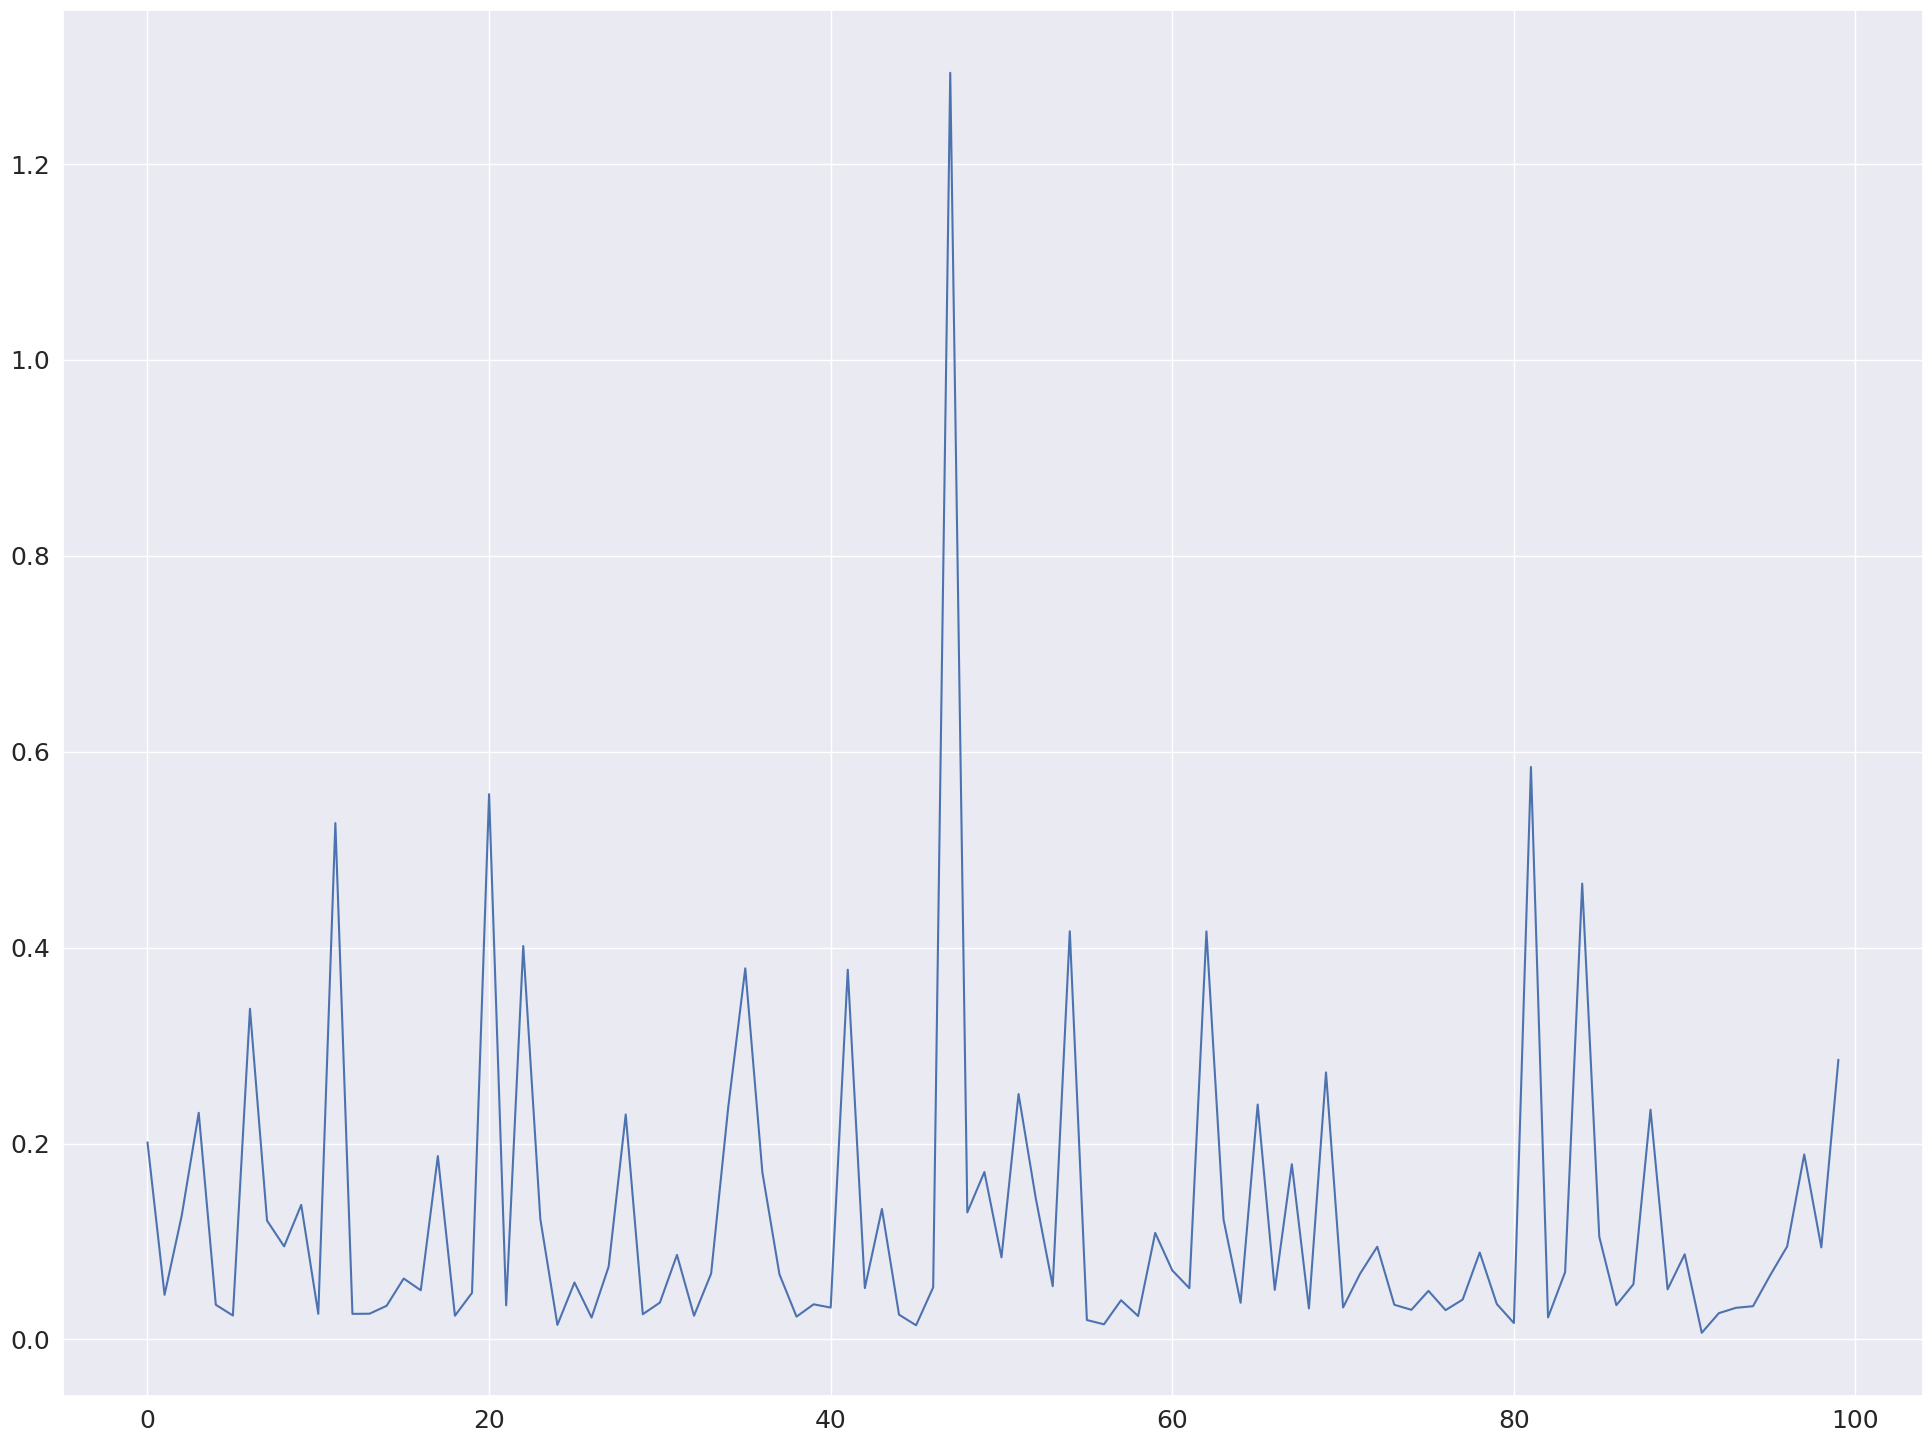

In [20]:
total_loss_list=[]
for i in result:
    total_loss_list.append(i[-1].detach().cpu())
plt.plot(total_loss_list)

In [21]:
result_std=torch.zeros((5,100))
for i in range(len(result)):
    result_std[0,i]=result[i][0].item()
    result_std[1,i]=result[i][1].item()
    result_std[2,i]=result[i][2].item()
    result_std[3,i]=result[i][3].item()
    result_std[4,i]=result[i][4].item()


In [22]:
result_std.std(dim=1)

tensor([0.0235, 0.0287, 0.0344, 0.0446, 0.0632])